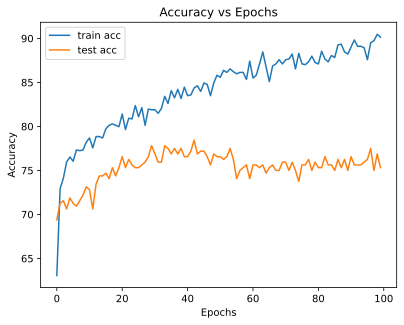

In [35]:
# imports
# for dl modeling
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn

# for data processing
import pandas as pd

# for numerical processing
import numpy as np
import scipy.stats as stats

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# to print progress
import sys

# read in data
df = pd.read_csv("winequality-red.csv", sep=";")
# print(df.shape)

# remove outliers
df = df[df["total sulfur dioxide"] < 200]

# get all columns except quality
cols2train = df.keys()
cols2train = cols2train.drop("quality")

# Data normalization zscore all cols except quality
for col in cols2train:
    df[col] = stats.zscore(df[col])

# converting to binary classification
df["quality"] = df["quality"].apply(lambda x: 1 if x >= 6 else 0)

# organise data
data = torch.tensor(df[cols2train].values).float()
labels = torch.tensor(df["quality"].values).float()
# making the labels 2D
labels = labels.unsqueeze(1)

# train test split
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=42
)
# print("train data shape: ", train_data.shape)
# print("test data shape: ", test_data.shape)

# making train and test datasets
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# making dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)


# ANN model
class ANN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input = nn.Linear(input_dim, 32)
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.input(x))
        x = nn.BatchNorm1d(32)(x)
        x = self.relu(self.fc1(x))
        x = nn.BatchNorm1d(64)(x)
        x = self.relu(self.fc2(x))
        x = nn.BatchNorm1d(32)(x)
        x = self.output(x)
        return x


# test the model
# model = ANN(input_dim=train_data.shape[1], output_dim=1)
# print(model)


# create model
def create_model(input_dim, output_dim):
    model = ANN(input_dim, output_dim)
    optmizer = torch.optim.SGD(model.parameters(), lr=0.01)
    loss_fn = nn.BCEWithLogitsLoss()
    return model, optmizer, loss_fn


# train model
def train_model(
    model, optimizer, loss_fn, train_dataloader, test_dataloader, epochs=100
):
    train_acc = np.zeros(epochs)
    test_acc = np.zeros(epochs)

    for epoch in range(epochs):
        # training
        model.train()
        batch_acc = []
        for inputs, labels in train_dataloader:
            preds = model(inputs)
            loss = loss_fn(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_acc.append(100 * torch.mean(((preds > 0) == labels).float()).item())

        # training accuracy
        train_acc[epoch] = np.mean(batch_acc)

        # testing
        model.eval()
        with torch.no_grad():
            inputs, labels = next(iter(test_dataloader))
            preds = model(inputs)
            test_acc[epoch] = 100 * torch.mean(((preds > 0) == labels).float()).item()
            
    return train_acc, test_acc


# train model
epochs = 100
model, optimizer, loss_fn = create_model(input_dim=train_data.shape[1], output_dim=1)
train_acc, test_acc = train_model(
    model, optimizer, loss_fn, train_loader, test_loader, epochs
)

# plot results
plt.plot(train_acc, label="train acc")
plt.plot(test_acc, label="test acc")
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [36]:
# predictions for training data
train_predictions = model(train_loader.dataset.tensors[0])

# predictions for test data
test_predictions = model(test_loader.dataset.tensors[0])

In [37]:
# using scikitlearn to compute ARPF
import sklearn.metrics as skm

# initialize vectors
train_metrics = [0,0,0,0]
test_metrics  = [0,0,0,0]

# training
train_metrics[0] = skm.accuracy_score (train_loader.dataset.tensors[1],train_predictions>0)
train_metrics[1] = skm.precision_score(train_loader.dataset.tensors[1],train_predictions>0)
train_metrics[2] = skm.recall_score   (train_loader.dataset.tensors[1],train_predictions>0)
train_metrics[3] = skm.f1_score       (train_loader.dataset.tensors[1],train_predictions>0)


# test
test_metrics[0] = skm.accuracy_score (test_loader.dataset.tensors[1],test_predictions>0)
test_metrics[1] = skm.precision_score(test_loader.dataset.tensors[1],test_predictions>0)
test_metrics[2] = skm.recall_score   (test_loader.dataset.tensors[1],test_predictions>0)
test_metrics[3] = skm.f1_score       (test_loader.dataset.tensors[1],test_predictions>0)

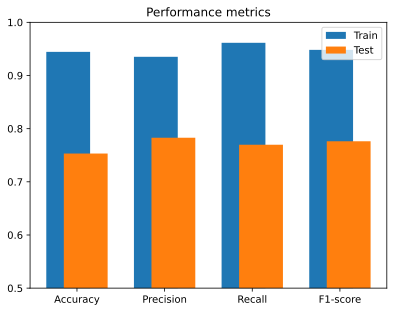

In [40]:
plt.bar(np.arange(4) - 0.1, train_metrics, 0.5)
plt.bar(np.arange(4) + 0.1, test_metrics, 0.5)
plt.xticks([0, 1, 2, 3], ["Accuracy", "Precision", "Recall", "F1-score"])
plt.ylim([0.5, 1])
plt.legend(["Train", "Test"])
plt.title("Performance metrics")
plt.show()

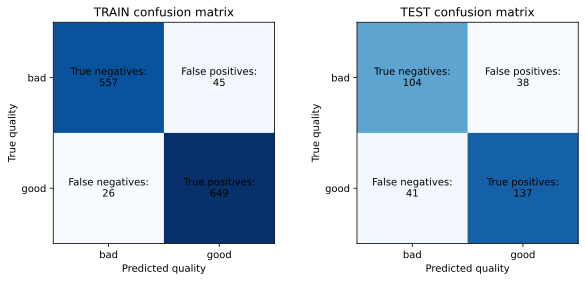

In [41]:
# Confusion matrices
trainConf = skm.confusion_matrix(train_loader.dataset.tensors[1], train_predictions > 0)
testConf = skm.confusion_matrix(test_loader.dataset.tensors[1], test_predictions > 0)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# confmat during TRAIN
ax[0].imshow(trainConf, "Blues", vmax=len(train_predictions) / 2)
ax[0].set_xticks([0, 1])
ax[0].set_yticks([0, 1])
ax[0].set_xticklabels(["bad", "good"])
ax[0].set_yticklabels(["bad", "good"])
ax[0].set_xlabel("Predicted quality")
ax[0].set_ylabel("True quality")
ax[0].set_title("TRAIN confusion matrix")

# add text labels
ax[0].text(0, 0, f"True negatives:\n{trainConf[0,0]}", ha="center", va="center")
ax[0].text(0, 1, f"False negatives:\n{trainConf[1,0]}", ha="center", va="center")
ax[0].text(1, 1, f"True positives:\n{trainConf[1,1]}", ha="center", va="center")
ax[0].text(1, 0, f"False positives:\n{trainConf[0,1]}", ha="center", va="center")


# confmat during TEST
ax[1].imshow(testConf, "Blues", vmax=len(test_predictions) / 2)
ax[1].set_xticks([0, 1])
ax[1].set_yticks([0, 1])
ax[1].set_xticklabels(["bad", "good"])
ax[1].set_yticklabels(["bad", "good"])
ax[1].set_xlabel("Predicted quality")
ax[1].set_ylabel("True quality")
ax[1].set_title("TEST confusion matrix")

# add text labels
ax[1].text(0, 0, f"True negatives:\n{testConf[0,0]}", ha="center", va="center")
ax[1].text(0, 1, f"False negatives:\n{testConf[1,0]}", ha="center", va="center")
ax[1].text(1, 1, f"True positives:\n{testConf[1,1]}", ha="center", va="center")
ax[1].text(1, 0, f"False positives:\n{testConf[0,1]}", ha="center", va="center")
plt.show()